<a href="https://colab.research.google.com/github/SonuDash/test_codes/blob/main/fashion_mnist_with_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Making another fashion MNIST model with CNN


Here we are just setting up the dataset as we did with our previous model. The actual model with CNN will be done below.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Number of training examples: 60000
Number of test exampes:      10000


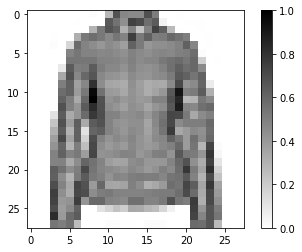

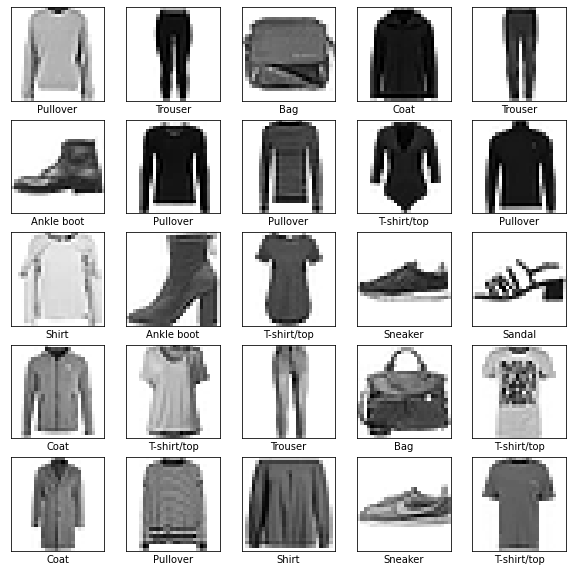

In [27]:
!pip install -U tensorflow_datasets
import tensorflow as tf
#import tensorflow datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

#Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

class_names = metadata.features['label'].names
print("Class names: {}".format(class_names))

num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test exampes:      {}".format(num_test_examples))

def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return  images, labels

"""The map function applies the normalize function to each element in the train
and test datasets""" 
train_dataset = train_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

""" The first time you use the datasets, the images willbe loaded from disk
caching will keep them in memory, making training faster """
train_dataset = train_dataset.cache()
test_dataset = test_dataset.cache()

#Take a single image, and remove the color dimension by reshaping
for image, label in test_dataset.take(1):
  break
image = image.numpy().reshape((28,28))

#Plot the image - voila a piece of fashion clothing
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(train_dataset.take(25)):
  image = image.numpy().reshape((28,28))
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image,cmap=plt.cm.binary)
  plt.xlabel(class_names[label])
plt.show()

##Building the model

In [28]:
model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), padding='same',activation=tf.nn.relu,
                                                    input_shape=(28,28,1)),
        tf.keras.layers.MaxPooling2D((2,2), strides=2),
        tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
        tf.keras.layers.MaxPooling2D((2,2), strides=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=tf.nn.relu),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [29]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [30]:
BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset =test_dataset.cache().batch(BATCH_SIZE)
model.fit(train_dataset, epochs=10, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/10
1875/1875 [==============================] - 16s 6ms/step - loss: 0.4058 - accuracy: 0.8537
Epoch 2/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2658 - accuracy: 0.9037
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2198 - accuracy: 0.9186
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1835 - accuracy: 0.9330
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1601 - accuracy: 0.9403
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1401 - accuracy: 0.9493
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1181 - accuracy: 0.9568
Epoch 8/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0977 - accuracy: 0.9635
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0850 - accuracy: 0.9691
Epoch 10/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0

##Make predictions and explore

In [31]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

In [32]:
predictions.shape

(32, 10)

In [33]:
predictions[0]

array([3.7628016e-08, 3.0114758e-10, 1.7801462e-06, 2.4733564e-11,
       9.9754566e-01, 2.6592739e-08, 2.4524799e-03, 7.8349024e-13,
       2.3866020e-11, 2.8284493e-09], dtype=float32)

In [34]:
np.argmax(predictions[0])

4

Graph for reviewing the predictions of full 10 sets.

In [35]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

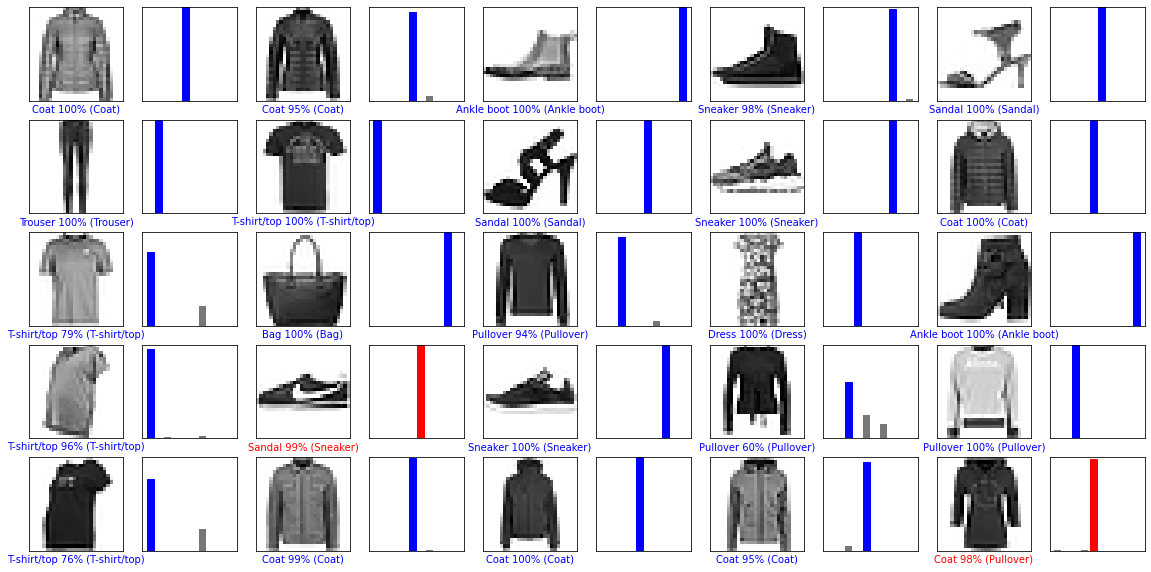

In [36]:
num_rows = 5
num_cols = 5
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)

In [37]:
img = test_images[0]

print(img.shape)

(28, 28, 1)


In [38]:
img = np.array([img])

print(img.shape)

(1, 28, 28, 1)


In [39]:
predictions_single = model.predict(img)

print(predictions_single)

[[3.7628091e-08 3.0114819e-10 1.7801445e-06 2.4733658e-11 9.9754566e-01
  2.6592943e-08 2.4524974e-03 7.8349469e-13 2.3866020e-11 2.8284493e-09]]


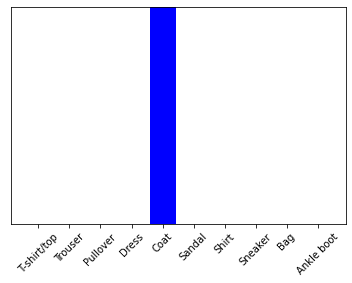

In [40]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

In [41]:
np.argmax(predictions_single[0])

4